In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import os, dotenv
project_path = os.path.dirname(dotenv.find_dotenv())

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

from src.features.build_features import series_to_supervised

import pickle

Using TensorFlow backend.
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


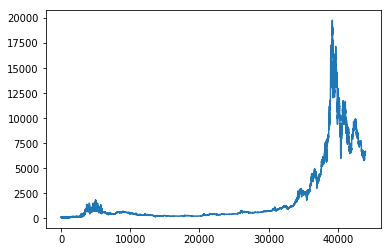

In [15]:
df = df = pd.read_csv(project_path + '/data/raw/data.csv', index_col=0)
# # Kept time because we will know the times at which we want predictions for - no problem with knowing the future.
df = df[['open','high','close','low','volumeto', 'volumefrom']]
# MAS = [6, 12,24,48]
# for MA in MAS:
#     df['vt_ma' + str(MA)] = df.volumeto.rolling(MA).mean()
#     df['vf_ma' + str(MA)] = df.volumefrom.rolling(MA).mean()
# #     df['close_ma' + str(MA)] = df.volumeto.rolling(MA).mean()
df.drop(['volumefrom', 'volumeto'], axis=1, inplace=True)
plt.plot(df['close'])

In [16]:
TRAIN_DATA_START_HOUR_INDEX = 36000
N_FEATURES = len(df.columns)
Tx = 72
Ty = 1

In [17]:
sample = df.iloc[TRAIN_DATA_START_HOUR_INDEX:,:]
sample.shape

(8002, 4)

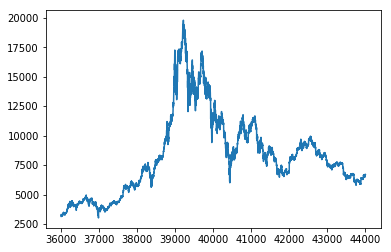

In [18]:
plt.plot(sample['close'])

In [19]:
X = series_to_supervised(data=sample, n_in=Tx, n_out=Ty)
Y = series_to_supervised(data=list(sample['close']), n_in=Tx, n_out=Ty)

In [20]:
"""
Train dev split. (80/20) rule is kind of over. Taking the dev set from the end of the data set because 
that data is closest in distribution to our current testing scenario (getting real time predictions). Note: I call
the dev set the 'test' set in the variable names, but it's really a dev set.
"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, shuffle=False)
"""
Now trim the feature values from the outcome matrix and the outcome values from the feature matrix
"""
Y_test_cache = Y_test
Y_train = Y_train.iloc[:,-Ty:]
Y_test = Y_test.iloc[:,-Ty:]
X_train = X_train.iloc[:,:-(Ty*N_FEATURES)]
X_test = X_test.iloc[:,:-(Ty*N_FEATURES)]


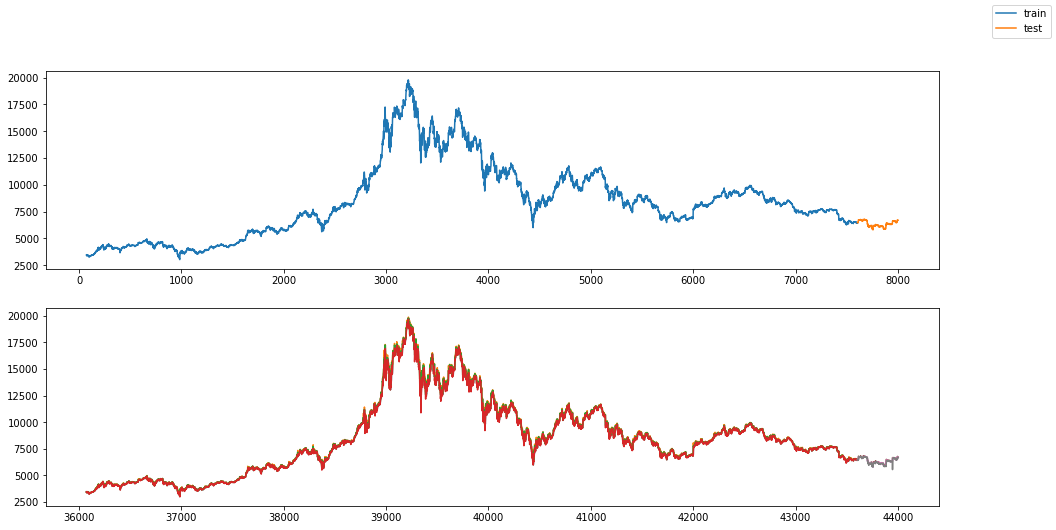

In [21]:
fig, ax = plt.subplots(2)
fig.set_size_inches(16,8)
ax[0].plot(Y_train, label='train')
ax[0].plot(Y_test, label='test')

ax[1].plot(X_train.iloc[:,-N_FEATURES:])
ax[1].plot(X_test.iloc[:,-N_FEATURES:])
fig.legend()

In [177]:
X_train=pd.read_csv('../data/processed/X_train.csv')
Y_train=pd.read_csv('../data/processed/Y_train.csv')
X_test=pd.read_csv('../data/processed/X_test.csv')
Y_test=pd.read_csv('../data/processed/Y_test.csv')

In [178]:
N_FEATURES=15
Tx=72

In [179]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
    dummy.fit(X_train, Y_train)
    dummy_predict = dummy.predict(X_test)
    print('{} Dummy MAE: {}'.format(strategy, mean_absolute_error(y_true=Y_test, y_pred=dummy_predict)))
    print('{} Dummy MSE: {}'.format(strategy, mean_squared_error(y_true=Y_test, y_pred=dummy_predict)))

mean Dummy MAE: 0.0039075242568042245
mean Dummy MSE: 6.374376799797876e-05
median Dummy MAE: 0.003908358929477728
median Dummy MSE: 6.373466127754362e-05
constant Dummy MAE: 0.0039044877026236744
constant Dummy MSE: 6.378635635411988e-05


In [180]:
"""
Scale the data for the RNN. Very important otherwise convergence would take a milenia.
"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, )
X_test_scaled = scaler.transform(X_test)
# pd.DataFrame(X_train_scaled)

# X_test_scaled = X_test.as_matrix()
# X_train_scaled = X_train.as_matrix()

In [181]:
"""
Have to reshape the model into a 3D array to fit the RNN Model.
"""
def shape_model_data(data, Tx, n_features):
    model_data = data.reshape((data.shape[0], Tx, n_features))
    return model_data
X_train_3D = shape_model_data(X_train_scaled, Tx, N_FEATURES)
X_test_3D = shape_model_data(X_test_scaled, Tx, N_FEATURES)

# import seaborn as sns
# fig, ax = plt.subplots()
# sns.lineplot(data=X_train_3D[7000,:,:], ax=ax)
# sns.lineplot(x=73, y=Y_train.iloc[7000],ax=ax, size=10, legend='full')
# sns.tsplot(Y_train.iloc[7000], ax=ax)

In [182]:
# from sklearn.preprocessing import Normalizer
# norm = Normalizer(norm=)
# Y_train_norm = norm.fit_transform(Y_train)
# Y_test_norm = norm.transform(Y_test)


In [183]:
from keras.layers import BatchNormalization, Conv1D, TimeDistributed, ZeroPadding1D, Activation, Input
from keras import Model

from keras.initializers import RandomNormal, Ones, Constant

def lstm_model(input_shape, num_outputs, kernel_init='normal', bias_init='zeros'):
    
    model_input = Input(shape=input_shape, dtype='float32')
    #     initializer = RandomNormal(mean=1.0, stddev=0.05, seed=0)

    model_output = LSTM(units=64, return_sequences=True, kernel_initializer=kernel_init, bias_initializer=bias_init, activation='relu')(model_input)
    model_output = BatchNormalization(axis=-1)(model_output)
    model_output = LSTM(units=64, return_sequences=False, kernel_initializer=kernel_init, bias_initializer=bias_init, activation='relu')(model_output)
    model_output = BatchNormalization(axis=-1)(model_output)
    model_output = Dense(num_outputs, kernel_initializer=kernel_init, bias_initializer=bias_init, activation='linear')(model_output)

    model = Model(inputs=model_input, outputs=model_output)
    return model


In [184]:
model=lstm_model(X_train_3D.shape[1:], Ty)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 72, 15)            0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 72, 64)            20480     
_________________________________________________________________
batch_normalization_34 (Batc (None, 72, 64)            256       
_________________________________________________________________
lstm_45 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_35 (Batc (None, 64)                256       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 54,081
Trainable params: 53,825
Non-trainable params: 256
_________________________________________________________________


In [185]:
epochs = 20
batch_size = 32
learning_rate=.001
decay_rate = learning_rate / epochs
"""
Compile and fit model.
"""
model.compile(loss='mae', optimizer=Adam(lr=learning_rate, decay=decay_rate), metrics=['mse'])

fit = model.fit(X_train_3D, Y_train,
                shuffle=False,
                epochs=epochs, 
                batch_size=batch_size, 
                validation_data=(X_test_3D, Y_test)
               )

Train on 5588 samples, validate on 295 samples
Epoch 1/20
5588/5588 [==============================] - 26s 5ms/step - loss: 0.1071 - mean_squared_error: 0.0232 - val_loss: 0.0334 - val_mean_squared_error: 0.0012
Epoch 2/20
5588/5588 [==============================] - 21s 4ms/step - loss: 0.0409 - mean_squared_error: 0.0038 - val_loss: 0.0060 - val_mean_squared_error: 7.9474e-05
Epoch 3/20
5588/5588 [==============================] - 21s 4ms/step - loss: 0.0160 - mean_squared_error: 5.0106e-04 - val_loss: 0.0079 - val_mean_squared_error: 1.0258e-04
Epoch 4/20
5588/5588 [==============================] - 20s 4ms/step - loss: 0.0145 - mean_squared_error: 3.9238e-04 - val_loss: 0.0044 - val_mean_squared_error: 6.9499e-05
Epoch 5/20
5588/5588 [==============================] - 20s 4ms/step - loss: 0.0132 - mean_squared_error: 3.2760e-04 - val_loss: 0.0043 - val_mean_squared_error: 7.0835e-05
Epoch 6/20
5588/5588 [==============================] - 25s 4ms/step - loss: 0.0139 - mean_squared_e

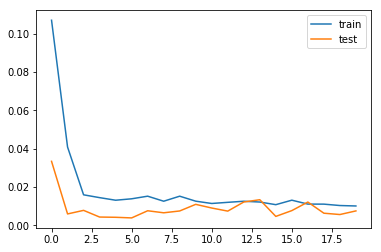

In [186]:
"""
Check out loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='test')
plt.legend()

In [187]:
prediction = model.predict(X_test_3D)
backtest=model.predict(X_train_3D)

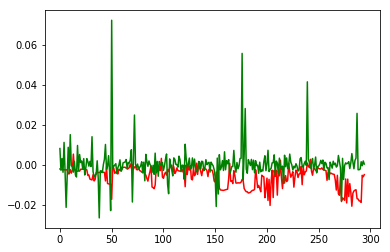

In [188]:
import matplotlib.pyplot as plt
plt.plot(prediction, 'r')
plt.plot(Y_test.values, 'g')

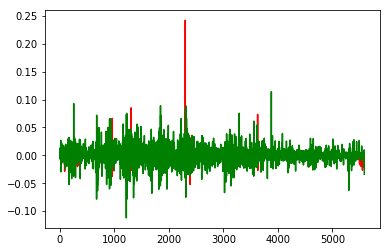

In [189]:
plt.plot(backtest, 'r')
plt.plot(Y_train.values, 'g')